# DS 453 / 653 Spring 2024: Project 2

---

_You must follow the Academic Code of Conduct and Collaboration Policy stated in the course syllabus at all times while working on this project._

This Jupyter notebook file explains the tasks that you must complete for Project 2. You must submit your final project on [Gradescope](https://www.gradescope.com/courses/497424). You have two opportunities to submit the project:

- The first submission date is Thursday, April 25. We will review your work and tell you whether you have passed, or otherwise what is needed to pass the project.
- The second submission date is Wednesday, May 1 at 8pm. You must complete the entire project by this time.

## Project Overview

The goal of this project is to construct a zero knowledge proof for a data science application. Specifically, we will look at a small-scale dataset and prove its linear regression.

(It is highly recommended that you complete Programming Assignment 9 before attempting this project, as we will continue to use the Circom language for zero knowledge proofs that was introduced in PA9 Task 2.)

### Dataset

In this project, we will use the famous Iris dataset. You can retrieve this dataset from the `sklearn` package using the code below. A few comments about the dataset and the parts that we will use in this project.

- The iris dataset contains 150 rows of data that measures 4 attributes about each iris. In this project, we will only consider the final two attributes: the petal length and petal width of each iris. Additionally, we will only look at a subset of 40 rows of the data that correspond to the iris versicolor species.

- The iris dataset in `sklearn` contains measurements in centimeters with one significant digit after the decimal point. Since it happens to be easier to work with integers in a cryptography project, let's multiply the petal widths by 10 (so the unit is now millimeters) and the petal lengths by 100 (so the unit is now multiples of $10^{-4}$ meters).

Below, I show a plot the data and its simple linear regression. In this project, let's treat the petal width as the independent variable, and petal length as the dependent variable. It turns out that the best-fit line is $y = 134 + 5x$.

x: [2. 1. 2. 2. 1. 1. 2. 4. 4. 3. 3. 3. 2. 4. 2. 5. 2. 2. 4. 2. 2. 2. 2. 4.
 1. 2. 2. 2. 2. 1. 2. 2. 3. 3. 2. 6. 4. 3. 2. 2.]
y: [140. 150. 150. 160. 140. 110. 120. 150. 130. 140. 170. 150. 170. 150.
 100. 170. 190. 160. 160. 150. 140. 160. 160. 150. 150. 140. 150. 120.
 130. 140. 130. 150. 130. 130. 130. 160. 190. 140. 160. 140.]


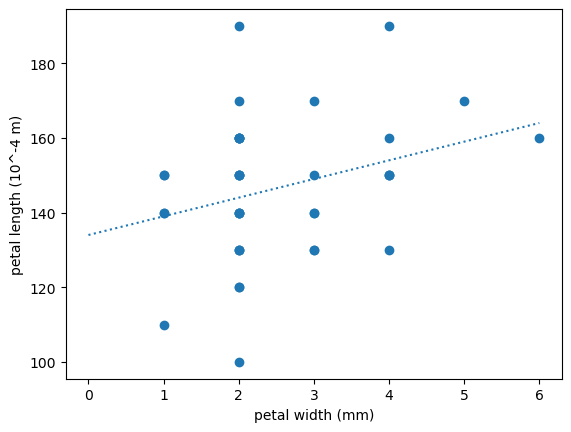

In [3]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# create an array containing the iris data
iris    = load_iris()
dataset = iris.data

# restricting to 40 rows of data and only two features
x_var = dataset[8:48,3] * 10  # petal width, in millimeters
y_var = dataset[8:48,2] * 100 # petal length, in units of 10^-4 meters

# print the data
print("x:", x_var)
print("y:", y_var)

# plot of the data
plt.scatter(x_var, y_var)
plt.xlabel("petal width (mm)")
plt.ylabel("petal length (10^-4 m)");

# regression line
ypoints = np.array([134 + 5*i for i in range(7)])
plt.plot(ypoints, linestyle = 'dotted');

### Scenario

In this project, you will take on the role of the prover Peggy in a zero-knowledge proof system. Let's imagine that you are the only person in the world who has the iris dataset (e.g., you collected all the data yourself but haven't shared it with the world).

Your task in this project is to *prove* that your data satisfies the linear regression $y = 134 + 5x$. You want to prove this property to the professor and teaching assistants, but you do not want to reveal the underlying dataset. We instructors will take on the role of the verifier Victor in the zero knowledge proof.

The project contains three tasks: calculating the linear regression, creating a commitment to the data, and creating a proof of the correctness of the computation.

## Task 1: Calculate linear regression

To begin this project, please calculate the single-variable linear regression for yourself (e.g., via the least-squares method). Remember to consider petal width as the independent variable and petal length as the dependent variable. Confirm for yourself that the best-fit line through all the data in `x_var` and `y_var` is $y = 134 + 5x$.

This task involves no cryptography. Just refresh your memory of linear regression and check the math for yourself. You might find [Prof. Crovella's course notes](https://mcrovella.github.io/CS132-Geometric-Algorithms/L23LinearModels.html#a-least-squares-problem) handy to remember the underlying matrix and vector algebra required to calculate the coefficients of the regression line.

__Your response:__

#### Solution: linregres()

In [13]:
from scipy.stats import linregress

r = linregress(x_var, y_var)

print(f"y = {r.intercept:.2f} + {r.slope:.2f}x")

y = 134.00 + 5.00x


#### Solution: Course Notes

In [5]:
X = np.column_stack([np.ones(x_var.shape[0], dtype = 'int'), x_var])

beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y_var

y_hat = X @ beta_hat

print(f"y = {beta_hat[0]:.2f} + {beta_hat[1]:.2f}x")

y = 134.00 + 5.00x


## Task 2: Create a commitment to the iris dataset

Next, create a cryptographic commitment to the iris data. Remember that a commitment is a digital equivalent to putting the data in an envelope: the verifier cannot see the data, and the prover cannot change it.

One way to create a cryptographic commitment is to use a hash function modeled as a random oracle. The following construction is a valid commitment, where `m` is the message to be committed and `r` is a secret random string.

$$
\begin{align*}
\operatorname{Commit}(m, r) &= H(m, r) \\
\operatorname{Open}(c, m, r) &= \text{reveal } m \text{ and } r \\
\end{align*}
$$

In this task, you must create a cryptographic commitment of the two columns of the iris dataset. You can use the code provided in Programming Assignment 9, Task 2 to help if you wish.

__Your response:__

In [14]:
import hashlib
import os

def commit(message, r):
    # creating a hash object
    H = hashlib.sha256()
    # adding message
    H.update(message.encode('utf-8'))
    # adding secret random sting
    H.update(r)
    # returning the digest
    return H.hexdigest()

def open(commitment, message, r):
    # commitment validity check
    return commit(message, r) == commitment

In [10]:
# generating random R values
r_values = [os.urandom(32) for _ in range(40)]

# creating commitments
commitments = []
for i in range(40):
    commitment = commit(f"{x_var[i]}_{y_var[i]}", r_values[i])
    commitments.append(commitment)

# checking the first commitment
first_commitment_validity = open(commitments[0], f"{x_var[0]}_{y_var[0]}", r_values[0])

print(f"First Commitment: {commitments[0]}")
print(f"Validity: {first_commitment_validity}")

First Commitment: 4942bee559f5b4eefe9ae0119e4885264c78d8c8a3c067d4758b683692c36aa5
Validity: True


## Task 3: Construct a ZK proof

Finally, create a zero knowledge proof in the language `Circom` to prove to the instructors that the linear regression curve is $y = 134 + 5x$ for the iris dataset that you committed to in Task 2.

In more detail: recall that a zero knowledge proof contains a public statement `x` and a private witness `w`. In this case:
- The public statement contains the linear regression from Task 1 and the commitment from Task 2. The idea of this project is that you want to share that with the instructors. Additionally, let's pretend that the commitment was checked by an auditor, peer-reviewer, or regulator; this third party has confirmed and attested to the fact that your dataset is properly produced, and us instructors believe them even though we have not seen the data ourselves.
- The private witness is the underlying iris data itself. Only you know that; we instructors haven't seen it.

So: you must create a ZK proof in `Circom` to show two properties about your secret iris dataset: that it is the message inside of the cryptographic commitment, and that its linear regression is as claimed.

_Write your Circom code below. We should be able to take this code and execute it ourselves on https://zkrepl.dev/. Also, make sure that your code is properly documented so we can understand what you have done. You may find it helpful to use the [Circom documentation](https://docs.circom.io/) as you write the proof. Additionally, see below for some code to perform matrix multiplication in Circom._

As a hint: calculating the linear regression requires calculating the inverse of a matrix. I highly recommend that you do _not_ try to perform matrix inversion yourself in `Circom`! Instead, remember that the goal of ZK is to __verify__ a calculation rather than performing the calculation yourself. As written in Prof. Crovella's course notes, it suffices to show that the correct vector of coefficients "$\bf{\beta}$ is a solution of the normal equations $X^\top X \bf{\beta} = X^\top \bf{y}$."

__Your response:__

In [1]:
pragma circom 2.1.5;
include "circomlib/circuits/comparators.circom";

// Matrix multiplication template (good)
template MatrixMultiply(row1, col1, row2, col2) {

    signal input mat1[row1][col1];
    signal input mat2[row2][col2];
    signal output mat3[row1][col2];

    assert(col1 == row2);

    // for each row of the output matrix
    for (var i = 0; i < row1; i++) {
        // for each column of the output matrix
        for (var j = 0; j < col2; j++) {
            
            // sum the product of the row of mat1 and the column of mat2
            var sum = 0;
            for (var k = 0; k < row2; k++) {
                sum += mat1[i][k] * mat2[k][j];
            }

            // assign the sum to the output matrix
            mat3[i][j] <-- sum;
        }
    }
}

// Matrix vector multiplication template ()
template MatrixVectorMultiply(row, col, vector_size) {
    signal input mat1[row][col];
    signal input vec1[vector_size];

    assert(col == vector_size);

    signal output vec2[row];

    // for each row and column of the matrix
    for (var i = 0; i < row; i++) {
        var sum = 0;
        for (var j = 0; j < col; j++) {
            
            // sum the product of the row of the matrix and the vector
            sum += mat1[i][j] * vec1[j];
        }
        vec2[i] <-- sum;
    }
}

template MatrixTranspose(row, col) {
    
    signal input mat1[row][col];
    signal output mat2[col][row];

    // for each row and column of the input matrix assign i,j to j,i in the output matrix
    for (var i = 0; i < row; i++) {
        for (var j = 0; j < col; j++) {
            mat2[j][i] <== mat1[i][j];
        }
    }
}

template Verify(row, col) {
    signal input X[row][col];
    signal input Y[row];
    signal input beta[col];

    signal output valid;

    ////////////////////////////////////////////////

    // TRANSPOSING X

    component transpose_X = MatrixTranspose(row, col);
    // input X
    transpose_X.mat1 <== X;
    // assign output X_T
    var X_T[col][row] = transpose_X.mat2;

    ////////////////////////////////////////////////
    
    // MATRIX MULTIPLICATION: X_T * X

    component matrix_multiply = MatrixMultiply(col, row, row, col);
    // input X_T and X
    matrix_multiply.mat1 <== X_T;
    matrix_multiply.mat2 <== X;

    // assign output X_T_X
    var X_T_X[col][col] = matrix_multiply.mat3;

    ////////////////////////////////////////////////
    
    // MATRIX VECTOR MULTIPLICATION: X_T_X * beta

    component matrix_vector_multiply = MatrixVectorMultiply(col, col, col);
    // input X_T_X and beta
    matrix_vector_multiply.mat1 <== X_T_X;
    matrix_vector_multiply.vec1 <== beta;

    // assign output X_T_X_beta
    var X_T_X_beta[col] = matrix_vector_multiply.vec2;

    ////////////////////////////////////////////////
    
    // MATRIX VECTOR MULTIPLICATION: X_T * Y

    component matrix_vector_multiply_Y = MatrixVectorMultiply(col, row, row);
    // input X_T and Y
    matrix_vector_multiply_Y.mat1 <== X_T;
    matrix_vector_multiply_Y.vec1 <== Y;

    // assign output X_T_Y
    var X_T_Y[col] = matrix_vector_multiply_Y.vec2;

    ////////////////////////////////////////////////
    
    // COMPARING X_T_X_beta and X_T_Y
    signal e1, e2;
    e1 <== 1 - (X_T_X_beta[0] - X_T_Y[0]) * (X_T_X_beta[0] - X_T_Y[0]);
    e2 <== 1 - (X_T_X_beta[1] - X_T_Y[1]) * (X_T_X_beta[1] - X_T_Y[1]);

    // if both errors are 0, the solution is valid
    valid <== e1 * e2;
}

component main {public [beta]} = Verify(40, 2);

/* INPUT = {
    "X": [["1","2"],["1","1"],["1","2"],["1","2"],["1","1"],["1","1"],["1","2"],["1","4"],["1","4"],["1","3"],["1","3"],["1","3"],["1","2"],["1","4"],["1","2"],["1","5"],["1","2"],["1","2"],["1","4"],["1","2"],["1","2"],["1","2"],["1","2"],["1","4"],["1","1"],["1","2"],["1","2"],["1","2"],["1","2"],["1","1"],["1","2"],["1","2"],["1","3"],["1","3"],["1","2"],["1","6"],["1","4"],["1","3"],["1","2"],["1","2"]], 
    "Y": ["140","150","150","160","140","110","120","150","130","140","170","150","170","150","100","170","190","160","160","150","140","160","160","150","150","140","150","120","130","140","130","150","130","130","130","160","190","140","160","140"]
    "beta": ["134","5"]
} */

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (3591429143.py, line 129)

## Documenting collaborators, sources, and AI tools

In accordance with the collaboration policy, use the space below to report if you used any resources to complete this homework assignment, aside from the lecture notes and the course textbooks/videos. Specifically, please report:

1. Names of all classmates you worked with, and a short description of the work that you performed together.
2. All written materials that you used, such as books or websites (besides the lecture notes or textbooks). Please include links to any web-based resources, or citations to any physical works.
3. All code that you used from other sources. In particular, if you used an AI tool, then you must include the entire exchange with the AI tool, as per the [CDS Generative AI Assistance Policy](https://www.bu.edu/cds-faculty/culture-community/gaia-policy/).

Remember that if we discover any undocumented collaborators, sources, or AI tools then this is grounds for a Not Passed grade on the project without the ability to resubmit, and possible referral to BU's Academic Conduct Committee (as described in the syllabus). It is in your own interest to document all collaborators, sources, and tools used!

__Your response:__

1. n/a
 
2. n/a

3. n/a

When you have completed the project, please submit this .ipynb file to Gradescope.

## Appendix: Example of matrix multiplication in Circom

In Task 3, you will need to write Circom code to check for the correct outcome for a matrix product. I reproduce below some Circom code from [GitHub user drgorillamd](https://github.com/drgorillamd/circom-halo2/blob/main/matrixProduct/circom/matrixProduct.circom) that can check whether the prover knows two secret matrices $A$ and $B$ that can multiply to produce a public matrix $C$. You can run this code for yourself at https://zkrepl.dev and confirm that it works.

Note that this code is *not* exactly what you will need for Task 3; in particular, in this project all matrices are meant to be secret except for the regression coefficients 134 and 5. Still though, you might find this code to be a useful starting point that you can adapt to fit the project.

In [ ]:
pragma circom 2.1.5;

include "../../node_modules/circomlib/circuits/comparators.circom";

// takes 2 private signals in (a and b) and a public one (c).
// checks if the matrix a[M][N] . b[N][P] == c[M][P]
// this is pretty useless as anyone can find A and B satisfying this, but it
// was funny to code tho.
// https://www.reddit.com/r/cryptography/s/kGMmhprA8N
template CheckMatrixProduct(M,N,P) {
    // A . B = C with dim(A) = MxN, dim(B)=NxP and dim(C)=NxN
    signal input a[M][N]; // private
    signal input b[N][P]; // private
    signal input c[M][P]; // public

    // compiler check: valid matrices (NOT a constrain)
    assert(M * N * P != 0);

    // 1 if the dot product a[x][i] . b[i][y] == c[x][y]
    component isDotProd[M][P];

    // for row in c
    for(var i = 0; i < M; i++) {
        // for col in c
        for(var j = 0; j < P; j++) {

            isDotProd[i][j] = IsDotProductEq(N);

            // Circom 2.1: pass a whole vector and this is so cool
            isDotProd[i][j].a <== a[i];

            // transposed
            for(var k = 0; k < N; k++) {
                isDotProd[i][j].b[k] <== b[k][j];
            }

            // the result in c
            isDotProd[i][j].dot_product <== c[i][j];

            isDotProd[i][j].isEqual === 1;
        }
    }
}

// Returns 1 if the dot product between 2 vectors a[N] and b[N] == dot_product
template IsDotProductEq(N) {
    signal input a[N];
    signal input b[N];
    signal input dot_product;

    signal output isEqual;

    // working vectors:
    // product of each value in a and b
    signal products[N];

    // cumulative sums of the products
    signal cum_sum[N];

    component isEq = IsEqual();

    // hold the first (rest iterate on i-1, avoid falling out of bound)
    products[0] <== a[0] * b[0];
    cum_sum[0] <== products[0];

    // compute a[i] * b[i] then add it to the cumulative sum
    for(var i = 1; i < N; i++) {
        products[i] <== a[i] * b[i];
        cum_sum[i] <== cum_sum[i - 1] + products[i];
    }

    // the last value of cum_sum now holds the dot product, just check for eq and return it
    isEq.in[0] <== dot_product;
    isEq.in[1] <== cum_sum[N - 1];
    isEqual <== isEq.out;
}

// Checks the matrix product, where c is a public matrix and a, b are hidden matrices
component main { public [ c ] } = CheckMatrixProduct(2, 3, 2);

/* INPUT = {
    "a": [["1", "2", "3"],
          ["4", "5", "6"]],
    "b": [["1", "2"],
          ["6", "7"],
          ["11", "12"]],
    "c": [["46", "52"],
          ["100", "115"]]
} */